In [1]:

from transformers import BertModel, BertTokenizer

model_name = "hfl/chinese-bert-wwm-ext"



In [2]:
import os
import torch
import json

from transformers import BertTokenizer
os.mkdir("./checkpoint/")
# class CommonConfig:
#     bert_dir = "./model_hub/chinese-bert-wwm-ext/"
#     output_dir = "./checkpoint/"
#     data_dir = "./data/"

class NerConfig:
    def __init__(self, data_name):
        # cf = CommonConfig()
        # self.bert_dir = cf.bert_dir
        # self.output_dir = cf.output_dir
        # self.output_dir = os.path.join(self.output_dir, data_name)
        # if not os.path.exists(self.output_dir):
        #     os.mkdir(self.output_dir)
        # self.data_dir = cf.data_dir

        label = ['O', 'B-BODY', 'I-BODY', 'B-SYMP', 'I-SYMP', 'B-INST', 'I-INST', 'B-EXAM', 'I-EXAM', 'B-CHEM',
         'I-CHEM', 'B-DISE', 'I-DISE', 'B-DRUG', 'I-DRUG', 'B-SUPP', 'I-SUPP', 'B-TREAT', 'I-TREAT', 'B-TIME', 'I-TIME']
        self.num_labels = len(label)
        self.label2id = {label: i for i, label in enumerate(label)}
        self.id2label = {i: label for i, label in enumerate(label)}

        self.max_seq_len = 510
        self.epochs = 1
        self.train_batch_size = 32
        self.dev_batch_size = 32
        self.bert_learning_rate = 3e-3
        self.crf_learning_rate = 3e-3
        self.adam_epsilon = 1e-8
        self.weight_decay = 0.01
        self.warmup_proportion = 0.01
        self.save_step = 500


In [3]:
import torch
import numpy as np

from torch.utils.data import Dataset

class NerDataset(Dataset):
    def __init__(self, data, args, tokenizer):
        self.data = data
        self.args = args
        self.tokenizer = tokenizer
        self.label2id = args.label2id
        self.max_seq_len = args.max_seq_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        text = self.data[item]["character"]
        labels = self.data[item]["character_label"]
        if len(text) > self.max_seq_len:
            text = text[:self.max_seq_len]
            labels = labels[:self.max_seq_len ]
        tmp_input_ids = self.tokenizer.convert_tokens_to_ids(["[CLS]"] + text + ["[SEP]"])
        attention_mask = [1] * len(tmp_input_ids)
        input_ids = tmp_input_ids + [0] * (self.max_seq_len - len(tmp_input_ids))
        attention_mask = attention_mask + [0] * (self.max_seq_len - len(tmp_input_ids))
        labels = [self.label2id[label] for label in labels]
        labels = [0] + labels + [0] + [0] * (self.max_seq_len - len(tmp_input_ids))

        input_ids = torch.tensor(np.array(input_ids))
        attention_mask = torch.tensor(np.array(attention_mask))
        labels = torch.tensor(np.array(labels))

        data = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }
        return data

In [4]:
import torch
import torch.nn as nn
!pip install pytorch-crf
from torchcrf import CRF
from transformers import BertModel, BertConfig

class ModelOutput:
  def __init__(self, logits, labels, loss=None):
    self.logits = logits
    self.labels = labels
    self.loss = loss

class BertNer(nn.Module):
  def __init__(self, args):
    super(BertNer, self).__init__()
    self.bert = BertModel.from_pretrained(model_name)
    hidden_size = 768
    self.lstm_hiden = 128
    self.max_seq_len = args.max_seq_len
    self.bilstm = nn.LSTM(hidden_size, self.lstm_hiden, 1, bidirectional=True, batch_first=True,
               dropout=0.1)
    self.linear = nn.Linear(self.lstm_hiden * 2, args.num_labels)
    self.crf = CRF(args.num_labels, batch_first=True)

  def forward(self, input_ids, attention_mask, labels=None):
    bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    seq_out = bert_output[0]  # [batchsize, max_len, 768]
    batch_size = seq_out.size(0)
    seq_out, _ = self.bilstm(seq_out)
    seq_out = seq_out.contiguous().view(-1, self.lstm_hiden * 2)
    seq_out = seq_out.contiguous().view(batch_size, self.max_seq_len, -1)
    seq_out = self.linear(seq_out)
    logits = self.crf.decode(seq_out, mask=attention_mask.bool())
    loss = None
    if labels is not None:
      loss = -self.crf(seq_out, labels, mask=attention_mask.bool(), reduction='mean')
    model_output = ModelOutput(logits, labels, loss)
    return model_output

In [5]:
import os
import json
import torch
import numpy as np

# from config import NerConfig
# from model import BertNer
# from data_loader import NerDataset

from tqdm import tqdm
!pip install seqeval

from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup, BertTokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 739.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=4b2b737837db82344025d4d82de0dd1f57621f539a85e44acc118e24b4b977fd
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [6]:
from google.colab import drive
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
!wget "https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py"
from conlleval import evaluate
class Trainer:
    def __init__(self,
                 output_dir=None,
                 model=None,
                 train_loader=None,
                 save_step=500,
                 dev_loader=None,
                 test_loader=None,
                 optimizer=None,
                 schedule=None,
                 epochs=1,
                 device="cuda",
                 id2label=None):
        self.output_dir = output_dir
        self.model = model
        self.train_loader = train_loader
        self.dev_loader = dev_loader
        self.test_loader = test_loader
        self.epochs = epochs
        self.device = device
        self.optimizer = optimizer
        self.schedule = schedule
        self.id2label = id2label
        self.save_step = save_step
        self.total_step = len(self.train_loader) * self.epochs

    def train(self):
        global_step = 1
        for epoch in range(1, self.epochs + 1):
            for step, batch_data in enumerate(self.train_loader):
                self.model.train()
                for key, value in batch_data.items():
                    batch_data[key] = value.to(self.device)
                input_ids = batch_data["input_ids"]
                attention_mask = batch_data["attention_mask"]
                labels = batch_data["labels"]
                output = self.model(input_ids, attention_mask, labels)
                loss = output.loss
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.schedule.step()
                print(f"【train】{epoch}/{self.epochs} {global_step}/{self.total_step} loss:{loss.item()}")
                global_step += 1
                if global_step % self.save_step == 0:
                     torch.save(self.model.state_dict(), os.path.join("./checkpoint/", "pytorch_model_ner.bin"))


        torch.save(self.model.state_dict(), os.path.join("./checkpoint/", "pytorch_model_ner.bin"))

    def test(self):
        self.model.load_state_dict(torch.load(os.path.join("./checkpoint/", "pytorch_model_ner.bin")))
        self.model.eval()
        preds = []
        trues = []
        p = []
        t = []
        with torch.no_grad():
          for step, batch_data in enumerate(tqdm(self.test_loader)):
            for key, value in batch_data.items():
                batch_data[key] = value.to(self.device)
            input_ids = batch_data["input_ids"]
            attention_mask = batch_data["attention_mask"]
            labels = batch_data["labels"]
            output = self.model(input_ids, attention_mask)
            logits = output.logits

            attention_mask = attention_mask.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()

            batch_size = input_ids.size(0)
            for i in range(batch_size):
                length = sum(attention_mask[i])
                length2 = sum(attention_mask[i]==0)
                print(length,length2)
                logit = logits[i][1:length]
                tag_logit = [self.id2label[i] for i in logit]
                label = labels[i][1:length]
                tag_label = [self.id2label[i] for i in label]
                preds.extend(tag_logit)
                trues.extend(tag_label)
                p.extend(logit)
                t.extend(label)

          print(preds)
          print(trues)

        conf_mtx = confusion_matrix(t, p)
        prec, rec, f1 = evaluate(trues, preds, verbose = True)
        return conf_mtx


def build_optimizer_and_scheduler(args, model, t_total):
    module = (
        model.module if hasattr(model, "module") else model
    )

    # 差分学习率
    no_decay = ["bias", "LayerNorm.weight"]
    model_param = list(module.named_parameters())

    bert_param_optimizer = []
    other_param_optimizer = []

    for name, para in model_param:
        space = name.split('.')
        # print(name)
        if space[0] == 'bert_module' or space[0] == "bert":
            bert_param_optimizer.append((name, para))
        else:
            other_param_optimizer.append((name, para))

    optimizer_grouped_parameters = [
        # bert other module
        {"params": [p for n, p in bert_param_optimizer if not any(nd in n for nd in no_decay)],
         "weight_decay": args.weight_decay, 'lr': args.bert_learning_rate},
        {"params": [p for n, p in bert_param_optimizer if any(nd in n for nd in no_decay)],
         "weight_decay": 0.0, 'lr': args.bert_learning_rate},

        # 其他模块，差分学习率
        {"params": [p for n, p in other_param_optimizer if not any(nd in n for nd in no_decay)],
         "weight_decay": args.weight_decay, 'lr': args.crf_learning_rate},
        {"params": [p for n, p in other_param_optimizer if any(nd in n for nd in no_decay)],
         "weight_decay": 0.0, 'lr': args.crf_learning_rate},
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=args.bert_learning_rate, eps=args.adam_epsilon)
    # optimizer = AdamW(model.parameters(),lr=args.bert_learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=int(args.warmup_proportion * t_total), num_training_steps=t_total
    )

    return optimizer, scheduler


--2024-01-01 19:34:47--  https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7502 (7.3K) [text/plain]
Saving to: ‘conlleval.py’

conlleval.py        100%[===================>]   7.33K  --.-KB/s    in 0s      

2024-01-01 19:34:47 (79.5 MB/s) - ‘conlleval.py’ saved [7502/7502]



In [7]:
data_name = "dgre"
args = NerConfig(data_name)

# with open(os.path.join(args.output_dir, "ner_args.json"), "w") as fp:
#     json.dump(vars(args), fp, ensure_ascii=False, indent=2)

tokenizer = BertTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# with open(os.path.join(args.data_path, "train.txt"), "r", encoding="utf-8") as fp:
#     train_data = fp.read().split("\n")
# train_data = [json.loads(d) for d in train_data]

# with open(os.path.join(args.data_path, "dev.txt"), "r", encoding="utf-8") as fp:
#     dev_data = fp.read().split("\n")
# dev_data = [json.loads(d) for d in dev_data]

drive.mount('/content/drive')
dataset = '/content/drive/MyDrive/hw_ner/deep_learning_final/train.json'#這裡我只用train去分成train和test
with open(dataset, "r", encoding="utf-8") as f:
  # train_data = [json.loads(line) for line in fp.read().split("\n") if line]
  train_data = f.read().split("\n")
  # print(train_data[1])
train_data = [json.loads(d) for d in train_data if d.strip()]
train_data, eval_data = train_test_split(train_data, test_size=0.4 ,shuffle=False)
dev_data, test_data = train_test_split(eval_data, test_size=0.5 ,shuffle=False)
train_dataset = NerDataset(train_data, args, tokenizer)
dev_dataset = NerDataset(dev_data, args, tokenizer)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=args.train_batch_size)
dev_loader = DataLoader(dev_dataset, shuffle=False, batch_size=args.dev_batch_size, num_workers=2)

model = BertNer(args)

# for name,_ in model.named_parameters():
#   print(name)

model.to(device)
t_toal = len(train_loader) * args.epochs
optimizer, schedule = build_optimizer_and_scheduler(args, model, t_toal)

train = Trainer(
    # output_dir=args.output_dir,
    model=model,
    train_loader=train_loader,
    # dev_loader=dev_loader,
    test_loader=dev_loader,
    optimizer=optimizer,
    schedule=schedule,
    epochs=args.epochs,
    device=device,
    id2label=args.id2label
    )

train.train()


tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

Mounted at /content/drive


pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


串流輸出內容已截斷至最後 5000 行。
【train】1/1 3448/8448 loss:3.8914318084716797
【train】1/1 3449/8448 loss:29.493732452392578
【train】1/1 3450/8448 loss:11.516304016113281
【train】1/1 3451/8448 loss:10.881731033325195
【train】1/1 3452/8448 loss:7.020713806152344
【train】1/1 3453/8448 loss:4.241912841796875
【train】1/1 3454/8448 loss:26.163192749023438
【train】1/1 3455/8448 loss:20.537452697753906
【train】1/1 3456/8448 loss:31.419742584228516
【train】1/1 3457/8448 loss:18.295066833496094
【train】1/1 3458/8448 loss:17.45641326904297
【train】1/1 3459/8448 loss:28.649089813232422
【train】1/1 3460/8448 loss:61.005760192871094
【train】1/1 3461/8448 loss:91.10926818847656
【train】1/1 3462/8448 loss:14.327522277832031
【train】1/1 3463/8448 loss:12.114814758300781
【train】1/1 3464/8448 loss:5.033905982971191
【train】1/1 3465/8448 loss:22.208324432373047
【train】1/1 3466/8448 loss:4.671087265014648
【train】1/1 3467/8448 loss:14.156436920166016
【train】1/1 3468/8448 loss:36.90609359741211
【train】1/1 3469/8448 loss:10.266555786132

In [ ]:

train = Trainer(
    # output_dir=args.output_dir,
    model=model,
    train_loader=train_loader,
    # dev_loader=dev_loader,
    test_loader=dev_loader,
    optimizer=optimizer,
    schedule=schedule,
    epochs=args.epochs,
    device=device,
    id2label=args.id2label
    )
confusion_mtx = train.test()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# report = train.test()
# print(report)

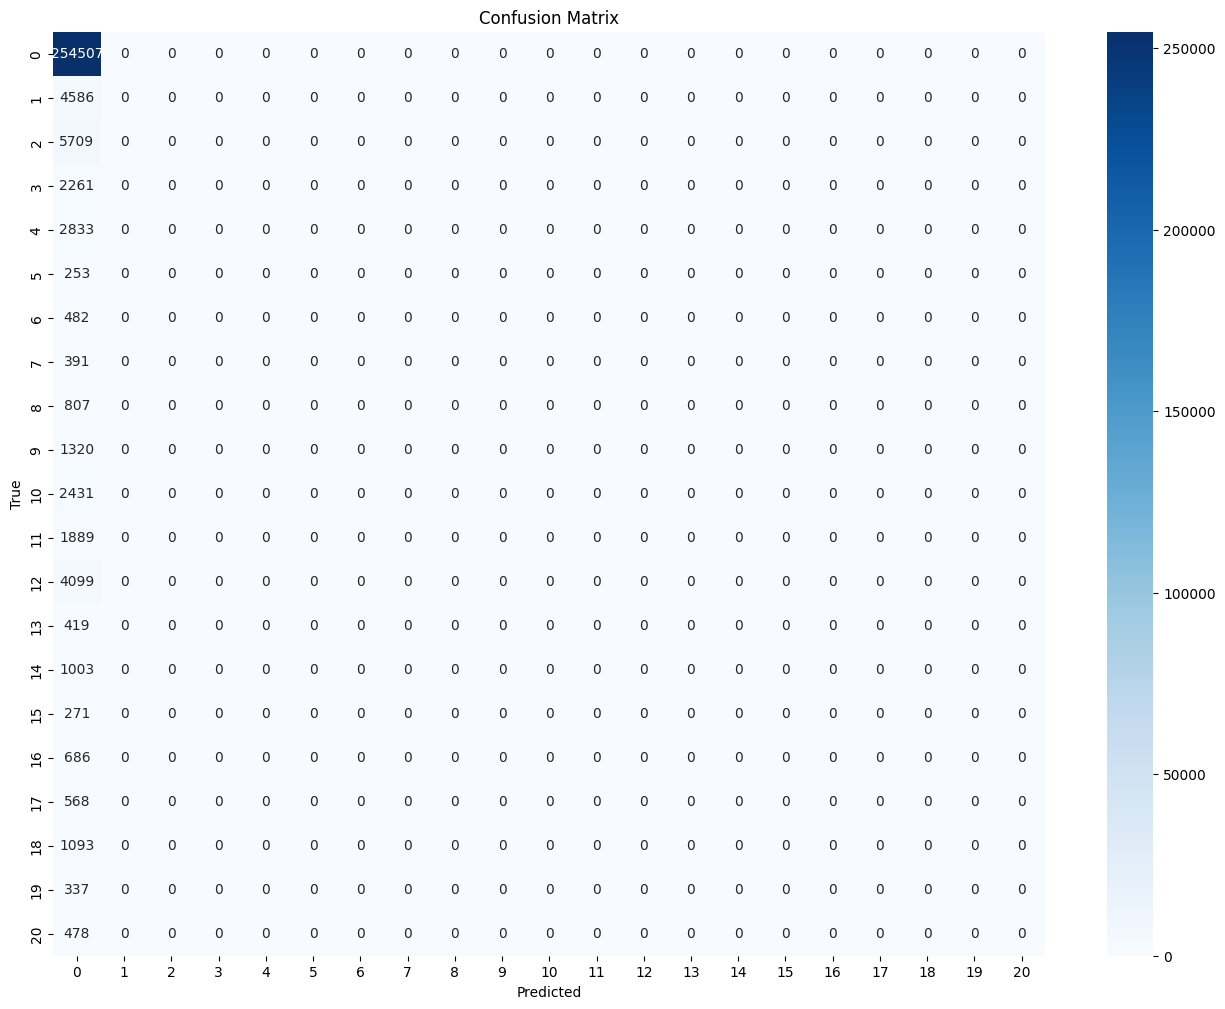

In [9]:
plt.figure(figsize=(16, 12))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()